In [15]:
import os
import re

from file_handling.file_read_writer import read_json, create_dir
import torch
from sentence_transformers import models, SentenceTransformer

import numpy as np
import pandas as pd

# !pip install fugashi
# !pip install unidic-lite 
# !pip install ipadic
# !pip install -U matplotlib

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## notebook outline: 
1. Extracting opinions by group
    - Read in each .json file from data/data_repr
        - For each folder(which is a party name) in data_repr
        - For each folder(which is a politician) in party
    - If it has info on LGBT, open json file and get `speaker_group` and `extracted_opinion`
    - Store in a dict w/ format `{'speaker_group': str, 'extracted_opinions': [str]'}`
    - Store as table with exploded `extracted_opinions`
2. Create BERT sentence embeddings for each sentence
3. Apply PCA to reduce embedding dimensionality and visualise

**TODO:**
- check validity of using PCA 
- correct `speaker_group`(?) --> change to follow path folder (collapse 18-->9)
- picking politicians as reference points 
    - https://www.cs.toronto.edu/~ashton/ --> Quantifying social organization and political polarization in online platforms 
    - https://github.com/CSSLab/social-dimensions/blob/main/full_code/social-dimensions.ipynb

## 1. Extracting opinions

In [50]:
def clean_str(sentence: str):
    """remove \r \n \u3000 and ○ from string"""  # TODO: check if I should add to this
    sentence = re.sub(r'[\r\n\u3000○]+', '', sentence)
    return sentence

DATA_DIR = os.path.join('data', 'data_repr')
data_rep_parties = os.listdir(DATA_DIR)[1:]  # excluding summary.json

party_folder = [os.path.join(DATA_DIR, parties) for parties in data_rep_parties]
party_path = [os.path.join(politician) for politician in party_folder]

# grab paths for each politician
politician_path = []
for party in party_path:
    for politician in os.listdir(party):
        politician_path.append(os.path.join(party, politician))

party_opinions = []  # list to store in the format {'party': str, 'extracted_opinions': [str]}

for politician in politician_path:
    if 'LGBT' in os.listdir(politician):  # TODO: change instances of 'LGBT' to variable `topic`
        topic_path = os.path.join(politician, 'LGBT')
        
        # get party info from party folder they're in (from path)
        party = politician.split("/")[2]

        for file in os.listdir(topic_path):
            topic_meeting_dict = read_json(os.path.join(topic_path, file))
            speeches = topic_meeting_dict['speeches']

            for speech in speeches:
                extracted_opinions = speech["extracted_opinions"]

                # clean extracted_opinions
                extracted_opinions = [clean_str(sentence) for sentence in extracted_opinions]

                # check if there's an existing entry for the speaker_group
                group_entry = next((entry for entry in party_opinions if entry['party'] == party), None)

                if group_entry: # if the entry exists, append the opinions to it
                    group_entry['extracted_opinions'].extend(extracted_opinions)

                else: # if the entry doesn't exist, create a new entry
                    party_opinions.append({"party": party, "extracted_opinions": extracted_opinions})
party_opinions

# convert dict to dataframe
df_party_opinions = pd.DataFrame(party_opinions).explode('extracted_opinions', ignore_index=True)
df_party_opinions

,party,extracted_opinions
0,公明,こういうところには、我々、国土交通省としてもしっかり意見交換をして対象とするようにしていきた...
1,公明,その上で、国の省令で要配慮者として位置付けるかについては、現在議論が行われているＬＧＢＴＱの...
2,公明,また、あわせて、共生社会担当大臣である小倉大臣におかれましては、是非とも性的マイノリティーの...
3,公明,コミュニケでは、「我々は、女性と男性、トランスジェンダー及びノンバイナリーの人々の間の平等を...
4,公明,Ｇ７各国は、自由や民主主義、人権などの基本的価値を共有していることがその基盤となっております...
...,...,...
2266,国民,日本とアメリカとスイスは留保していますけれども、憲法上の理由もあると思いますが、留保していい...
2267,国民,我々国民民主党が神奈川県で擁立した方は、非常に強力な差別的発言を受けて深く傷ついていらっしゃいます
2268,国民,どうしてもっと憤らないのか
2269,国民,そういう方々が選挙の場で行われた差別的発言にどうしてもっと怒らないのか


<!-- # opinions_by_group = {} # dict to keep track of extracted opinions by speaker group
# party_opinions = []  # list to store in the format {'speaker_group': str, 'extracted_opinions': [str]}

# for politician in politician_path:

#     # check for `topic` in each politician
#     if 'LGBT' in os.listdir(politician):  # TODO: change instances of 'LGBT' to variable `topic`
#         topic_path = os.path.join(politician, 'LGBT')

#         for file in os.listdir(topic_path):
#             topic_meeting_dict = read_json(os.path.join(topic_path, file))
#             speeches = topic_meeting_dict['speeches']

#             for speech in speeches:
#                 speaker_group = speech["speaker_group"]
#                 extracted_opinions = speech["extracted_opinions"]

#                 # clean extracted_opinions
#                 for i, sentence in enumerate(extracted_opinions):
#                     extracted_opinions[i] = clean_str(sentence)

#                 # if speaker_group already exists in opinions_by_group
#                 if speaker_group in opinions_by_group:
#                     # combine extracted_opinions by speaker_group 
#                     opinions_by_group[speaker_group].extend(extracted_opinions)

#                 else: # if speaker_group doesn't exist, create a new entry
#                     opinions_by_group[speaker_group] = extracted_opinions

# party_opinions = [{"speaker_group": group, "extracted_opinions": opinions} for group, opinions in opinions_by_group.items()]

# # # TODO: to convert to df
# # df_party_opinions = pd.DataFrame(party_opinions)
# # df_party_opinions = df_party_opinions.explode('extracted_opinions', ignore_index=True)
# # df_party_opinions -->


## 2. Sentence embeddings

In [51]:
test = party_opinions[:2] # only two parties

# turn into a dataframe 
df_test = pd.DataFrame(test).explode('extracted_opinions', ignore_index=True)
df_test

,party,extracted_opinions
0,公明,こういうところには、我々、国土交通省としてもしっかり意見交換をして対象とするようにしていきた...
1,公明,その上で、国の省令で要配慮者として位置付けるかについては、現在議論が行われているＬＧＢＴＱの...
2,公明,また、あわせて、共生社会担当大臣である小倉大臣におかれましては、是非とも性的マイノリティーの...
3,公明,コミュニケでは、「我々は、女性と男性、トランスジェンダー及びノンバイナリーの人々の間の平等を...
4,公明,Ｇ７各国は、自由や民主主義、人権などの基本的価値を共有していることがその基盤となっております...
...,...,...
1481,立憲,多発させる不祥事で逃げるのはやめてほしい
1482,立憲,第一次補正も秋以降になるなら、救える命が救えません
1483,立憲,この一事を取ってしても総辞職に値するものです
1484,立憲,政治は、国民のものであり、最高の倫理でなくてはなりません


In [52]:
# adapted from: https://osima.jp/posts/sentence-bert/
model_name = "cl-tohoku/bert-base-japanese"

sentence_transformer = models.Transformer(model_name)

pooling = models.Pooling(
    sentence_transformer.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=False,
    pooling_mode_cls_token=True,
    pooling_mode_max_tokens=False)

st = SentenceTransformer(modules=[sentence_transformer, pooling])

encoded_opinions = st.encode(df_test['extracted_opinions'], convert_to_tensor=True, show_progress_bar=True)
# print(f"{sentence_embeddings.shape} / {type(sentence_embeddings)}")

Batches: 100%|██████████| 47/47 [04:47<00:00,  6.11s/it]


# 3. pca + plot

/Users/annabellepurnomo/miniforge3/envs/torch-nightly/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/annabellepurnomo/miniforge3/envs/torch-nightly/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26126 (\N{CJK UNIFIED IDEOGRAPH-660E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/annabellepurnomo/miniforge3/envs/torch-nightly/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31435 (\N{CJK UNIFIED IDEOGRAPH-7ACB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/annabellepurnomo/miniforge3/envs/torch-nightly/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25010 (\N{CJK UNIFIED IDEOGRAPH-61B2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


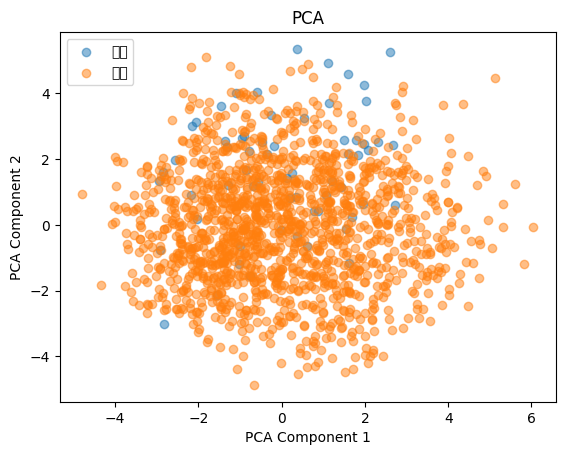

In [54]:
# from matplotlib.font_manager import FontProperties
# from matplotlib import rcParams

# plt.rcParams["font.family"] = 'IPAexGothic'
# TODO: add japanese fonts to plt 

def pcaPlot(df):
    # TODO: make make into separate functions 

    # PCA  
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(encoded_opinions)

    # df containing PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA Component 1', 'PCA Component 2'])

    # add the speaker_group column to the PCA DataFrame
    pca_df['party'] = df['party']

    # plot pca, colour=speaker_group

    # get Component 1 and 2, and speaker_group 
    for i, party in enumerate(df['party'].unique()):
        group_data = pca_df[pca_df['party'] == party] # create subset of data for each unique `speaker_group`
        plt.scatter(group_data['PCA Component 1'], group_data['PCA Component 2'], label=party, alpha=0.5)

    plt.legend(loc='best')
    plt.title('PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# pcaPlot(df_party_opinions) # all 18 parties
pcaPlot(df_test) # 公明党 and 民進党・無所属クラブ

# 公明党
# 民進党・無所属クラブ
# 民主・維新・無所属クラブ
# 立憲民主党・無所属
# 立憲民主党・市民クラブ
# 希望の党・無所属クラブ
# 民主党・無所属クラブ
# 立憲民主・国民・社保・無所属フォーラム
# 国民民主党・無所属クラブ
# 立憲民主党・無所属フォーラム
# 有志の会
# 日本共産党
# 日本維新の会
# れいわ新選組
# 自由民主党・無所属の会
# 自由民主党
# 立憲民主・社民
# 自由民主党・こころ